# Mask generating algorithm

In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Load Model

In [16]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: Siamese cat, Siamese


# Load MaskGeneratingModel

In [17]:
from maskgen.models.mask_generating_model12 import MaskGeneratingModel
mask_gen_model = MaskGeneratingModel(pred_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_0_90.pth'))
# mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_final_4_39.pth'))
mask_gen_model.eval()

patch_size = 16
print()

## Show Example

# Demo trained examples

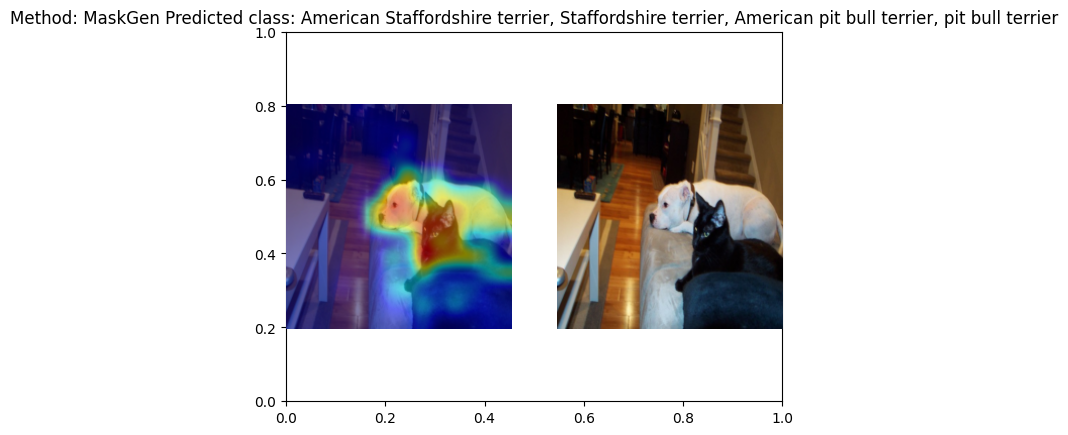

In [18]:
from maskgen.utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=patch_size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

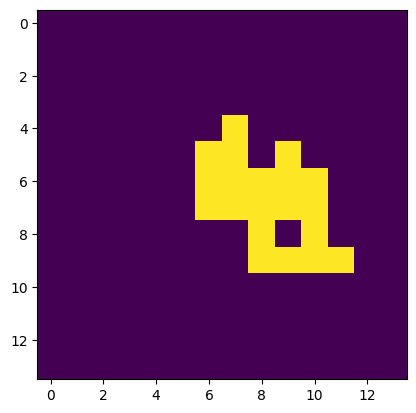

In [19]:
# test_mask = obtain_masks_on_topk(heatmap, 20, 'ins')
plt.imshow((heatmap > np.quantile(heatmap, 0.9)))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.show()

In [20]:
# from maskgen.utils import idx_to_selector

# def get_sampled_heatmap(img, sim, pseudo_label, n_samples=10):
#     predicted_class_selector = idx_to_selector(pseudo_label, 1000)
#     sampled_mask_list = []
#     for _ in range(n_samples):
#         sampled_mask, sampled_mask_prob, _, _ = mask_gen_model.sample_one_step(img, sim, predicted_class_selector=predicted_class_selector)
#         sampled_mask_list.append(sampled_mask * sampled_mask_prob)

#     heatmap = torch.stack(sampled_mask_list).mean(0).reshape(-1, 16, 16)
#     return heatmap

# n_samples = 100
# with torch.no_grad():
#     inputs = processor(images=image, return_tensors="pt")
#     inputs.to(device)
#     img = inputs['pixel_values']
#     img = img.to(device)
#     pseudo_label = pred_model(img).logits.argmax(-1)
#     predicted_class_idx = pseudo_label.item()
    
#     sim = mask_gen_model(img)['sim']

# plt.title(f"MaskGen_G Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
# # heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=14)
# # heatmap_list = [mask_gen_model.generate_mask(sim) for _ in range(n_samples)]

# # heatmap = torch.stack(heatmap_list).mean(0).reshape(-1, 16, 16)
# heatmap = get_sampled_heatmap(img, sim, pseudo_label, n_samples=n_samples)
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

# Batch Evaluation

In [29]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 100
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
# test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [22]:
from maskgen.evaluation import EvalGame
from tqdm import tqdm

# n_samples = 100

# random_mask
root_path = 'results/maskgen-vit'
topk = 10

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0


# def get_sampled_heatmap(img, sim, pseudo_label, n_samples=10):
#     predicted_class_selector = idx_to_selector(pseudo_label, 1000)
#     sampled_mask_list = []
#     for _ in range(n_samples):
#         sampled_mask, sampled_mask_prob, _, _ = mask_gen_model.sample_one_step(img, sim, predicted_class_selector=predicted_class_selector)
#         sampled_mask_list.append(sampled_mask * sampled_mask_prob)

#     heatmap = torch.stack(sampled_mask_list).mean(0).reshape(-1, 16, 16)
#     return heatmap
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attr = mask_gen_model.attribute_img(pixel_values, image_size=224, patch_size=patch_size) # [1,14,14]
    # sim = mask_gen_model(pixel_values)['sim']
    # attr = get_sampled_heatmap(pixel_values, sim, pseudo_label, n_samples=n_samples)


    # heatmap = attr.squeeze(1) # [1, 14, 14]
    heatmap = attr # [1, 14, 14]
    # heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    heatmap_list.append(heatmap)
    if (idx + 1) * batch_size % 100 == 0:
        heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
        save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
        heatmap_list = []

    with torch.no_grad():
        input_img = pixel_values
        ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
        del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

        # append to list
        ins_score_list.append(ins_score)
        del_score_list.append(del_score)
    
    if idx >= 10:
        break

if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# heatmap = heatmap_list

10it [00:47,  4.80s/it]


In [23]:
# plt.imshow(attr[1].detach().cpu().numpy())

In [24]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

print(ins_score.mean())
print(del_score.mean())
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = input_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
# tensor(0.6749, device='cuda:0')
# tensor(0.0431, device='cuda:0')

tensor(0.2478, device='cuda:0')
tensor(0.6507, device='cuda:0')


Predicted class: sea lion


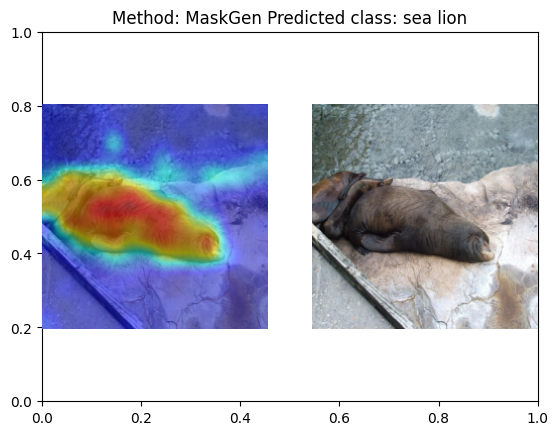

ins_score: tensor(0.0001, device='cuda:0')
del_score: tensor(0.9987, device='cuda:0')


In [25]:
from maskgen.utils.img_utils import plot_overlap_np

idx = 32

predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = heatmap[idx].detach().cpu().numpy()
img = input_img[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
plt.annotate(f"ins_score: {ins_score_list[-1][idx]:.4f}", (0, 10))
plt.annotate(f"del_score: {del_score_list[-1][idx]:.4f}", (0, 20))

img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

print("ins_score:", ins_score_list[-1][idx])
print("del_score:", del_score_list[-1][idx])

In [26]:
heatmap[0]

tensor([[0.0843, 0.0953, 0.0846, 0.0985, 0.0965, 0.0851, 0.0829, 0.1053, 0.1107,
         0.1042, 0.0860, 0.0735, 0.0747, 0.0774],
        [0.1012, 0.0950, 0.1246, 0.0991, 0.1014, 0.1018, 0.1092, 0.1077, 0.1045,
         0.0998, 0.0995, 0.0945, 0.0973, 0.1019],
        [0.0648, 0.1007, 0.0995, 0.1175, 0.1106, 0.1153, 0.1171, 0.1240, 0.1396,
         0.1395, 0.0945, 0.1133, 0.0977, 0.1064],
        [0.1022, 0.1105, 0.0868, 0.1071, 0.1363, 0.1474, 0.1945, 0.1795, 0.1867,
         0.1495, 0.0967, 0.0992, 0.0647, 0.1241],
        [0.0991, 0.0934, 0.0958, 0.0978, 0.1491, 0.1522, 0.1642, 0.1486, 0.1410,
         0.1105, 0.1096, 0.0955, 0.1142, 0.1052],
        [0.1165, 0.0976, 0.1033, 0.1479, 0.1918, 0.1796, 0.1581, 0.1366, 0.1392,
         0.1458, 0.0942, 0.1180, 0.1122, 0.1024],
        [0.0870, 0.1219, 0.1243, 0.1680, 0.1371, 0.1651, 0.1432, 0.1436, 0.1749,
         0.1485, 0.1085, 0.1023, 0.1052, 0.0930],
        [0.1362, 0.1149, 0.0857, 0.1586, 0.1589, 0.1287, 0.1773, 0.1564, 0.1831,
  

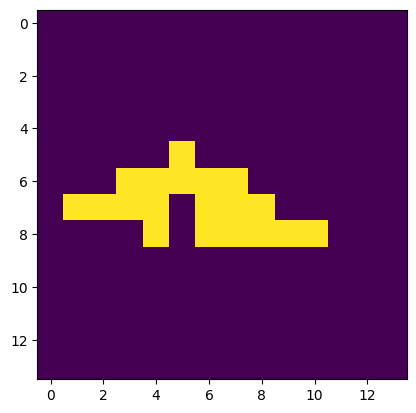

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


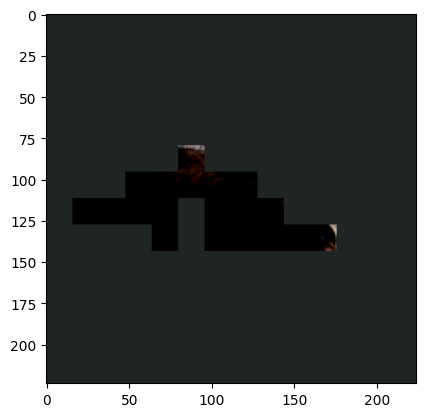

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


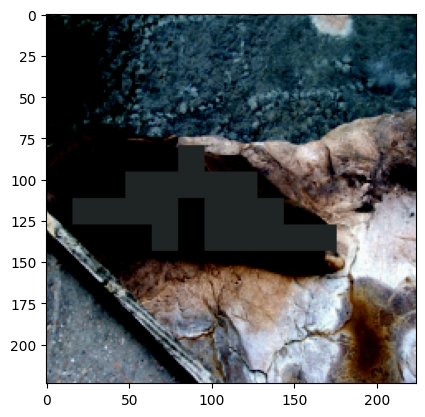

In [27]:
from maskgen.evaluation import obtain_masks_on_topk, obtain_masked_input_on_topk

test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]

mode = 'ins'
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode)
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode)
test_masked_img2 = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')

# plt.imshow((heatmap[idx] > torch.quantile(heatmap[idx], 0.8)).float().cpu().numpy())
plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
plt.show()
plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(test_masked_img2[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [28]:
from maskgen.evaluation import EvalGame, obtain_masks_on_topk, obtain_masked_input_on_topk
test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]
# eval_game.get_deletion_at_topk(test_img, test_heatmap, topk)
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode='del')
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk)
 # [N, 1, H_a, W_a]
resized_mask = F.interpolate(test_mask.unsqueeze(1), size=test_img.shape[-2:], mode='nearest')

test_predicted_class_idx = pred_model(test_masked_img).logits.argmax(-1)
print("Predicted class:", pred_model.config.id2label[test_predicted_class_idx.item()])

# probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
# print(eval_game.get_score_at_topk(test_img, test_heatmap, 20, mode='del'))

test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')
probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
print(probs[:,439])


test_masked_img = obtain_masked_input_on_topk(test_img, test_mask, topk)


pseudo_label = self.model(x).argmax(-1) # [1, 1]
probs = torch.softmax(self.model(masked_input), dim=-1) # [N, 1000]

selector = idx_to_selector(pseudo_label, self.output_dim) # [N, 1000]
probs = (probs * selector).sum(-1) # [N,]
return probs # [N,]



plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.imshow((test_masked_img * resized_mask)[0].detach().cpu().numpy().transpose(1, 2, 0))

Predicted class: hog, pig, grunter, squealer, Sus scrofa
tensor([2.2695e-07], device='cuda:0')


NameError: name 'self' is not defined

In [ ]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)